<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RANSAC plane

RANdom SAmple Consensus (RANSAC) is an iterative method to make robust nondeterministic estimation of parameters of a mathematical model from a set of data containing outliers.

If is very popular in pointcloud segmentation tasks.The steps of the algorthm:

1. Set up tolerance and the number of iterations
2. Select three random points from the point cloud
3. Find the plane of the randomly selected points
4. Find the inliers, which are closer to the plane than the tolerance
5. If the number of inliers is larger than in any previous solution save the solution as the best sofar
6. Repeat from step 2 if the number of iterations allows

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi, sin, cos
# parameters
tolerance = 0.02        # distance from the plane to accept point
iterations = 1000       # number of iterations

Let's generate random points close to a plane and some outliers. For the test data set first points on a horizontal plane and random outliers are genarated. In a second step points are rotated around X and Y axices by random angles between 10 and 80 degree.

In [3]:
n = 1000 # number of inliers
m = 600  # number of outliers
range = 100.0   # range of x, y, z coordinates from zero to range

# points on a horizontal plane
x = np.random.rand(n + m) * range
y = np.random.rand(n + m) * range
z = np.zeros(n + m)
z[0:n] = np.random.rand(n) * tolerance + range / 2.0    # on plane
z[n:n+m] = np.random.rand(m) * range                    # noise
# random rotate points to have general plane
alpha, beta = np.random.randint(10, 80, 2) / 180.0 * pi
r1 = np.array([[1.0, 0.0, 0.0], [0.0, cos(alpha), -sin(alpha)], [0.0, sin(alpha), cos(alpha)]])
r2 = np.array([[cos(beta), 0.0, sin(beta)], [0.0, 1.0, 0.0], [-sin(beta), 0.0, cos(beta)]])
r = r1.dot(r2)
# rotate points
points = np.c_[x, y, z].dot(r)

Let's display the points. Change the two angles (degrees) in *view_init* to change the point of view. The first angle is the azimut, the second is the elevation angle. For example a top view is (0, 90), a front view is (0, 0).

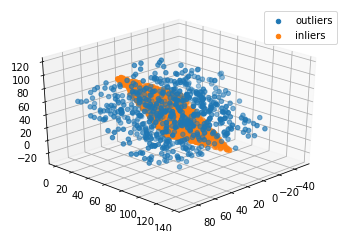

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[n:n+m, 0], points[n:n+m, 1], points[n:n+m, 2], label='outliers')
ax.scatter(points[0:n, 0], points[0:n, 1], points[0:n, 2], label='inliers')
ax.legend()
ax.view_init(30, 45) 

Iteration to find RANSAC plane. The plane parameters (a, b, c, d) are calculated using homogenouos coordinates. 

In [ ]:
if points.shape[1] < 4:
    points = np.c_[points, np.full((n+m, 1), 1)]    # change to homogenouos coord
best_n = 0          # number of points on the best plane so far
best_i = 0          # iteration index of best plane so far
best_inliers = np.array([]) # indices of inliers of the best plane so far
for i in np.arange(iterations):
    # select three random points
    l = []  # list of random indices for points
    while len(l) != 3:
        l = list(set(np.random.randint(n+m, size=3))) # remove repeated random integers
    pp = points[l]  # randomly selected points
    # plane equation from the three points using homogenouos coordinates
    a = np.linalg.det(pp[:,1:])
    b = -np.linalg.det(pp[:, [0, 2, 3]])
    c = np.linalg.det(pp[:, [0, 1, 3]])
    d = -np.linalg.det(pp[:, 0:3])
    plane = np.array([a, b, c, d])
    plane = plane / np.sqrt(plane[0:3].dot(plane[0:3]))   # normal to unit vector
    # select close points
    inliers = points[np.abs(np.dot(points, plane)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers[:,:3].copy()
        best_plane = plane.copy()
print(f'Best solution after {best_i} iterations, {best_n} points on plane: {best_plane}')

Best solution after 53 iterations, 1000 points on plane: [ 0.17652828 -0.96594251 -0.18918995 50.00842103]


*Try* to run the block above several times and check best_i and best_n to fine tune the number interations. Do you get the same result is you repeat the calculation?

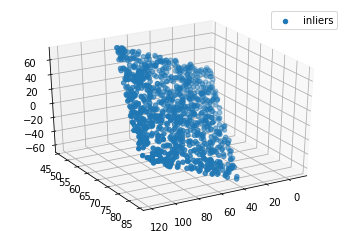

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(best_inliers[:, 0], best_inliers[:, 1], best_inliers[:, 2], label='inliers')
#ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='outliers')
ax.legend()
ax.view_init(30, 60)

**Tasks**

- Run the iteration block above and check *best_i* and *best_n* to fine tune interation number.

# Find multiple planes in a point cloud

Mostly we are looking for not a single plane but the simplified model of the object in the point cloud. In this sample we try to find the faces (linear) of a geometrical object.

The Open3D Python package can handle point clouds and RANSAC planes. We'll use it.

In [ ]:
!pip install open3d

A small point cloud of a building will be used, let's download it from GitHub

In [11]:
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/house.pcd -O sample_data/house.pcd

Find six planes having most of the points.

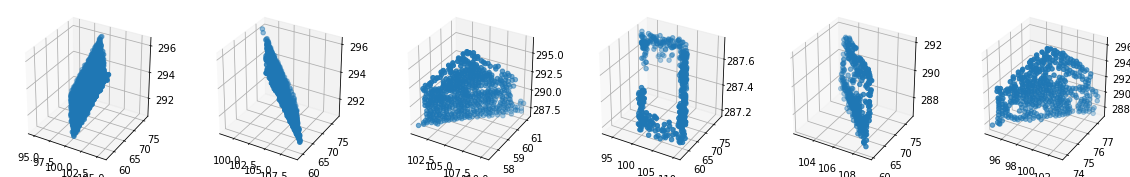

In [48]:
import open3d as o3d
import numpy as np

n_planes = 6
tol = 0.1           # tolerance distance from plane
n_points = 3        # number of random points
iterations = 100
# load point cloud
pc = o3d.io.read_point_cloud('sample_data/house.pcd')
pc_orig = pc.select_by_index([], invert=True)   # make a copy of original
planes = []     # list of result planes
fig = plt.figure(figsize=(20, 3))

i = 0
while i < n_planes:
    plane, inliers = pc.segment_plane(tol, n_points, iterations)
    plane_pc = pc.select_by_index(inliers)
    ax = fig.add_subplot(1, 6, i+1, projection='3d')
    xyz = np.asarray(plane_pc.points)
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    #ch = plane_pc.compute_convex_hull()
    planes.append([plane, plane_pc])
    pc = pc.select_by_index(inliers, invert=True)   # rest of the point cloud
    i += 1


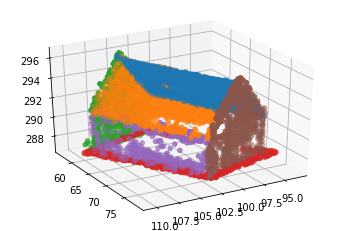

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for pp in planes:
    xyz = np.asarray(pp[1].points)
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2])
ax.view_init(30, 60)